# Predicting Loan Delinquency

Financial institutions in the consumer credit business offer loans with personalized interest rates. Many of these customers may not have a long enough credit history for financial institutions to rely only on credit scores to offer loans. The ability to estimate the probablity of a loan being charged-off would significantly reduce the credit risk associated with these loans.

This project aims to predict loans that could go bad, even before they are sanctioned. 

## Importing dependencies

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Set max columns and rows for displaying large dataframes
pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999)

## Preparing the dataset

The primary dataset for training and validating loan default predictions have been obtained from [Kaggle](https://www.kaggle.com/wendykan/lending-club-loan-data/download%E2%80%9D).

In [2]:
data = pd.read_csv('loan.csv', nrows=1000000, low_memory=False)

In [3]:
data.head(3)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,2500,2500,2500.0,36 months,13.56,84.92,C,C1,Chef,10+ years,RENT,55000.0,Not Verified,Dec-2018,Current,n,NaN,NaN,debt_consolidation,Debt consolidation,109xx,NY,18.24,0,Apr-2001,1.0,NaN,45.0,9,1,4341,10.3,34,w,2386.02,2386.02,167.02,167.02,113.98,53.04,0.0,0.0,0.0,Feb-2019,84.92,Mar-2019,Feb-2019,0,NaN,1,Individual,NaN,NaN,NaN,0,0,16901,2.0,2.0,1.0,2.0,2.0,12560.0,69.0,2.0,7.0,2137.0,28.0,42000,1.0,11.0,2.0,9,1878.0,34360.0,5.9,0,0,140.0,212,1,1,0,1.0,NaN,2.0,NaN,0,2,5,3,3,16,7,18,5,9,0.0,0,0,3,100.0,0.0,1,0,60124,16901,36500,18124,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,30000,30000,30000.0,60 months,18.94,777.23,D,D2,Postmaster,10+ years,MORTGAGE,90000.0,Source Verified,Dec-2018,Current,n,NaN,NaN,debt_consolidation,Debt consolidation,713xx,LA,26.52,0,Jun-1987,0.0,71.0,75.0,13,1,12315,24.2,44,w,29387.75,29387.75,1507.11,1507.11,612.25,894.86,0.0,0.0,0.0,Feb-2019,777.23,Mar-2019,Feb-2019,0,NaN,1,Individual,NaN,NaN,NaN,0,1208,321915,4.0,4.0,2.0,3.0,3.0,87153.0,88.0,4.0,5.0,998.0,57.0,50800,2.0,15.0,2.0,10,24763.0,13761.0,8.3,0,0,163.0,378,4,3,3,4.0,NaN,4.0,NaN,0,2,4,4,9,27,8,14,4,13,0.0,0,0,6,95.0,0.0,1,0,372872,99468,15000,94072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,5000,5000,5000.0,36 months,17.97,180.69,D,D1,Administrative,6 years,MORTGAGE,59280.0,Source Verified,Dec-2018,Current,n,NaN,NaN,debt_consolidation,Debt consolidation,490xx,MI,10.51,0,Apr-2011,0.0,NaN,NaN,8,0,4599,19.1,13,w,4787.21,4787.21,353.89,353.89,212.79,141.10,0.0,0.0,0.0,Feb-2019,180.69,M

In [4]:
data.shape

(1000000, 145)

### Target

Let us first explore the target column - loan_status.

In [5]:
target='loan_status'

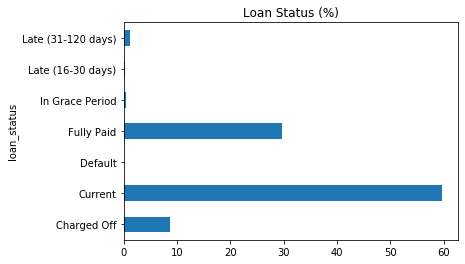

In [6]:
df = 100 * data.groupby(['loan_status'])['loan_amnt'].count() / data['loan_amnt'].count()
df.plot.barh(title='Loan Status (%)', rot=0)
plt.show()

Now, let's transform the different loan_status categories to either 'good' or 'bad'.

In [7]:
status = {
    'Charged Off': 'bad',
    'Current': 'good',
    'Default': 'bad',
    'Does not meet the credit policy. Status:Charged Off': 'bad',
    'Does not meet the credit policy. Status:Fully Paid': 'good',
    'Fully Paid': 'good',
    'In Grace Period': 'bad',
    'Late (16-30 days)': 'bad',
    'Late (31-120 days)': 'bad'
}
data['loan_status'] = data['loan_status'].map(lambda x: status[x])

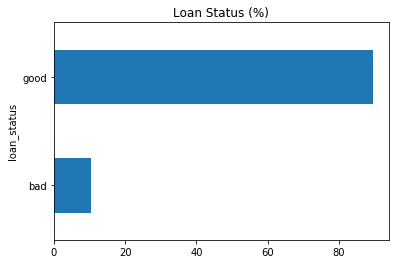

In [8]:
df = 100 * data.groupby(['loan_status'])['loan_amnt'].count() / data['loan_amnt'].count()
df.plot.barh(title='Loan Status (%)', rot=0)
plt.show()

### Feature Reduction

Some features are not available to us at the time of sanctioning loans. These features must be removed from the dataset. 

In [9]:
columns = [
    'id','member_id','url','funded_amnt_inv','total_acc', 'out_prncp', 'out_prncp_inv', 'open_acc', 'total_pymnt_inv', 
    'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 
    'last_pymnt_amnt', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med', 
    'acc_now_delinq', 'acc_open_past_24mths', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt', 
    'mort_acc', 'mths_since_recent_bc', 'percent_bc_gt_75', 'pub_rec_bankruptcies', 'tax_liens', 'total_bal_ex_mort', 
    'total_bc_limit', 'hardship_flag', 'debt_settlement_flag', 'total_pymnt', 'next_pymnt_d', 'tot_coll_amt', 'hardship_type', 
    'hardship_reason', 'hardship_status', 'deferral_term', 'hardship_amount', 'hardship_start_date', 'hardship_end_date', 
    'payment_plan_start_date', 'hardship_length', 'hardship_dpd','hardship_loan_status', 
    'orig_projected_additional_accrued_interest', 'hardship_payoff_balance_amount', 'hardship_last_payment_amount',
    'debt_settlement_flag_date', 'settlement_status', 'settlement_date', 'settlement_amount', 'settlement_percentage', 
    'settlement_term'
]
data.drop(columns=np.intersect1d(columns, data.columns), inplace=True)

### Feature Transformation

The 'term' feature has the string 'months' appended to its numerical values. This needs to be removed. 

In [10]:
data['term'] = data['term'].dropna().map(lambda term: int(term.replace("months", "").strip()))

Some features have dates. So, let's retain only the year from the dates. 

In [11]:
columns=['issue_d', 'earliest_cr_line']
for col in np.intersect1d(columns, data.columns):
    data[col] = data[col].dropna().map(lambda date: int(date.split('-')[1].strip()))

### Finally

In [12]:
data.head(3)

,loan_amnt,funded_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,pub_rec,revol_bal,revol_util,initial_list_status,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,avg_cur_bal,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,tot_hi_cred_lim,total_il_high_credit_limit,revol_bal_joint,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,disbursement_method
0,2500,2500,36,13.56,84.92,C,C1,Chef,10+ years,RENT,55000.0,Not Verified,2018,good,n,NaN,debt_consolidation,Debt consolidation,109xx,NY,18.24,0,2001,1.0,NaN,45.0,1,4341,10.3,w,NaN,1,Individual,NaN,NaN,NaN,16901,2.0,2.0,1.0,2.0,2.0,12560.0,69.0,2.0,7.0,2137.0,28.0,42000,1.0,11.0,2.0,1878.0,140.0,212,1,1,NaN,2.0,NaN,0,2,5,3,3,16,7,18,5,9,0.0,0,0,3,100.0,60124,18124,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash
1,30000,30000,60,18.94,777.23,D,D2,Postmaster,10+ years,MORTGAGE,90000.0,Source Verified,2018,good,n,NaN,debt_consolidation,Debt consolidation,713xx,LA,26.52,0,1987,0.0,71.0,75.0,1,12315,24.2,w,NaN,1,Individual,NaN,NaN,NaN,321915,4.0,4.0,2.0,3.0,3.0,87153.0,88.0,4.0,5.0,998.0,57.0,50800,2.0,15.0,2.0,24763.0,163.0,378,4,3,NaN,4.0,NaN,0,2,4,4,9,27,8,14,4,13,0.0,0,0,6,95.0,372872,94072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash
2,5000,5000,36,17.97,180.69,D,D1,Administrative,6 years,MORTGAGE,59280.0,Source Verified,2018,good,n,NaN,debt_consolidation,Debt consolidation,490xx,MI,10.51,0,2011,0.0,NaN,NaN,0,4599,19.1,w,NaN,1,Individual,NaN,NaN,NaN,110299,0.0,1.0,0.0,2.0,14.0,7150.0,72.0,0.0,2.0,0.0,35.0,24100,1.0,5.0,0.0,18383.0,87.0,92,15,14,NaN,14.0,NaN,0,0,3,3,3,4,6,7,3,8,0.0,0,0,0,100.0,136927,10000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash


In [13]:
data.shape

(1000000, 89)

## Visualizing the data

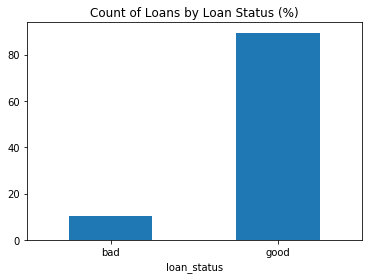

In [14]:
df = 100 * data.groupby(['loan_status'])['loan_amnt'].count() / data['loan_amnt'].count()
df.plot.bar(title='Count of Loans by Loan Status (%)', rot=0)
plt.show()

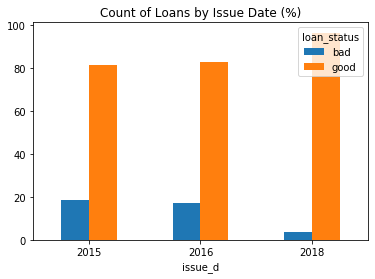

In [15]:
df = 100 * data.groupby(['loan_status', 'issue_d'])['loan_amnt'].count() / data.groupby(['issue_d'])['loan_amnt'].count()
df.unstack(level=0).plot.bar(title='Count of Loans by Issue Date (%)', rot=0)
plt.show()

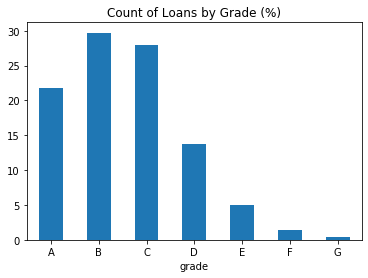

In [16]:
df = 100 * data.groupby(['grade'])['loan_amnt'].count() / data['loan_amnt'].count()
df.plot.bar(title='Count of Loans by Grade (%)', rot=0)
plt.show()

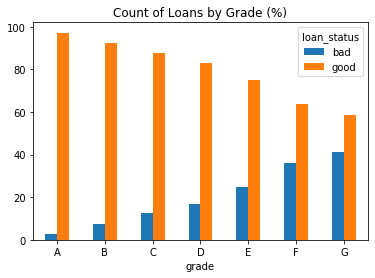

In [17]:
df = 100 * data.groupby(['loan_status', 'grade'])['loan_amnt'].count() / data.groupby(['grade'])['loan_amnt'].count()
df.unstack(level=0).plot.bar(title='Count of Loans by Grade (%)', rot=0)
plt.show()

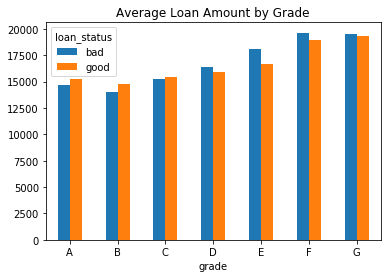

In [18]:
df = data.groupby(['loan_status', 'grade'])['loan_amnt'].mean()
df.unstack(level=0).plot.bar(title='Average Loan Amount by Grade', rot=0)
plt.show()

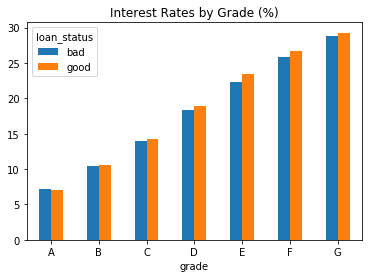

In [19]:
df = data.groupby(['loan_status', 'grade'])['int_rate'].mean()
df.unstack(level=0).plot.bar(title='Interest Rates by Grade (%)', rot=0)
plt.show()

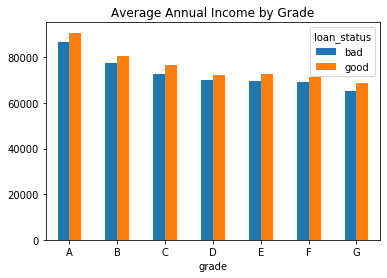

In [20]:
df = data.groupby(['loan_status', 'grade'])['annual_inc'].mean()
df.unstack(level=0).plot.bar(title='Average Annual Income by Grade', rot=0)
plt.show()

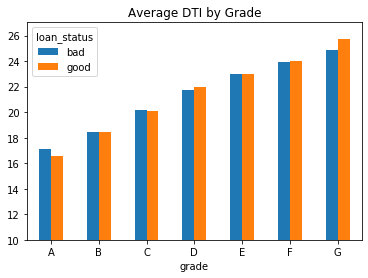

In [21]:
df = data.groupby(['loan_status', 'grade'])['dti'].mean()
df.unstack(level=0).plot.bar(title='Average DTI by Grade', rot=0, ylim=10)
plt.show()

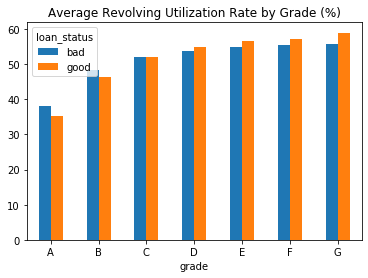

In [22]:
df = data.groupby(['loan_status', 'grade'])['revol_util'].mean()
df.unstack(level=0).plot.bar(title='Average Revolving Utilization Rate by Grade (%)', rot=0)
plt.show()

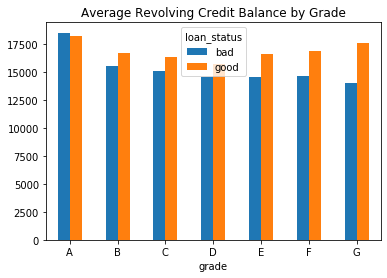

In [23]:
df = data.groupby(['loan_status', 'grade'])['revol_bal'].mean()
df.unstack(level=0).plot.bar(title='Average Revolving Credit Balance by Grade', rot=0)
plt.show()

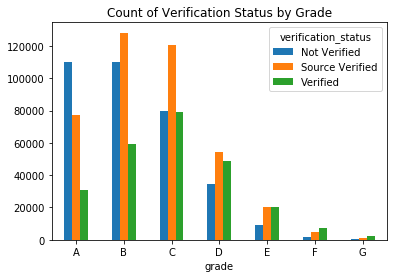

In [24]:
df = data.groupby(['verification_status', 'grade'])['loan_amnt'].count()
df.unstack(level=0).plot.bar(title='Count of Verification Status by Grade', rot=0)
plt.show()

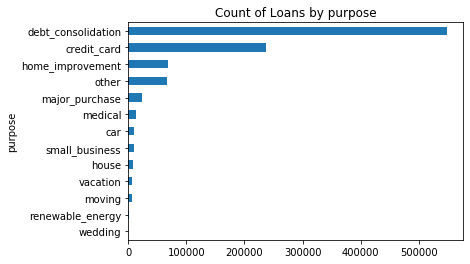

In [25]:
df = data.groupby(['purpose'])['loan_amnt'].count()
df.sort_values().plot.barh(title='Count of Loans by purpose', rot=0)
plt.show()

## Preprocessing the data

### Handling missing values

Some columns have critical data which cannot be assumed or inferred. If rows are found to have missing values in such columns, they need to be ignored.

In [26]:
columns = ['loan_status', 'loan_amnt', 'dti', 'annual_inc']
data.dropna(subset=np.intersect1d(columns, data.columns), inplace=True)

Some features have too many missing values and cannot be imputed efficiently. So, let's drop them. 

In [27]:
data.dropna(axis='columns', thresh=data.shape[0]*0.99, inplace=True)

Missing values will be imputed. 

### Encoding Categorical Features

In [28]:
data.dtypes

loan_amnt                       int64
funded_amnt                     int64
term                            int64
int_rate                      float64
installment                   float64
grade                          object
sub_grade                      object
home_ownership                 object
annual_inc                    float64
verification_status            object
issue_d                         int64
loan_status                    object
pymnt_plan                     object
purpose                        object
zip_code                       object
addr_state                     object
dti                           float64
delinq_2yrs                     int64
earliest_cr_line                int64
inq_last_6mths                float64
pub_rec                         int64
revol_bal                       int64
revol_util                    float64
initial_list_status            object
policy_code                     int64
application_type               object
tot_cur_bal 

In [29]:
from sklearn.preprocessing import LabelEncoder

for col in data.select_dtypes(exclude=['int64', 'float64']).columns:
    # Fill missing values in column with empty string
    data[col].fillna('', inplace=True)

    # Encode categorical feature
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])

### Finally

In [30]:
data.head(3)

,loan_amnt,funded_amnt,term,int_rate,installment,grade,sub_grade,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,pub_rec,revol_bal,revol_util,initial_list_status,policy_code,application_type,tot_cur_bal,total_rev_hi_lim,avg_cur_bal,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,tot_hi_cred_lim,total_il_high_credit_limit,disbursement_method
0,2500,2500,36,13.56,84.92,2,10,3,55000.0,0,2018,1,0,2,101,33,18.24,0,2001,1.0,1,4341,10.3,1,1,0,16901,42000,1878.0,212,1,1,0,2,5,3,3,16,7,18,5,9,0,0,3,100.0,60124,18124,0
1,30000,30000,60,18.94,777.23,3,16,1,90000.0,1,2018,1,0,2,661,17,26.52,0,1987,0.0,1,12315,24.2,1,1,0,321915,50800,24763.0,378,4,3,0,2,4,4,9,27,8,14,4,13,0,0,6,95.0,372872,94072,0
2,5000,5000,36,17.97,180.69,3,15,1,59280.0,1,2018,1,0,2,472,21,10.51,0,2011,0.0,0,4599,19.1,1,1,0,110299,24100,18383.0,92,15,14,0,0,3,3,3,4,6,7,3,8,0,0,0,100.0,136927,10000,0


In [31]:
data.shape

(998803, 49)

## Modeling

In [32]:
from sklearn.model_selection import train_test_split

X = data.drop(target, axis='columns', inplace=False)
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=123)

### Feature Selection

In [33]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

# create a Random Forest Classifier pipeline
rf_pipeline = Pipeline([
    ('imputer', SimpleImputer()), # fill missing values with mean of column
    ('scaler', MinMaxScaler()), # scale values to range [0,1]
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=123, n_jobs=-1))
])
rf_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('imputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('classifier',
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=-1,
                             

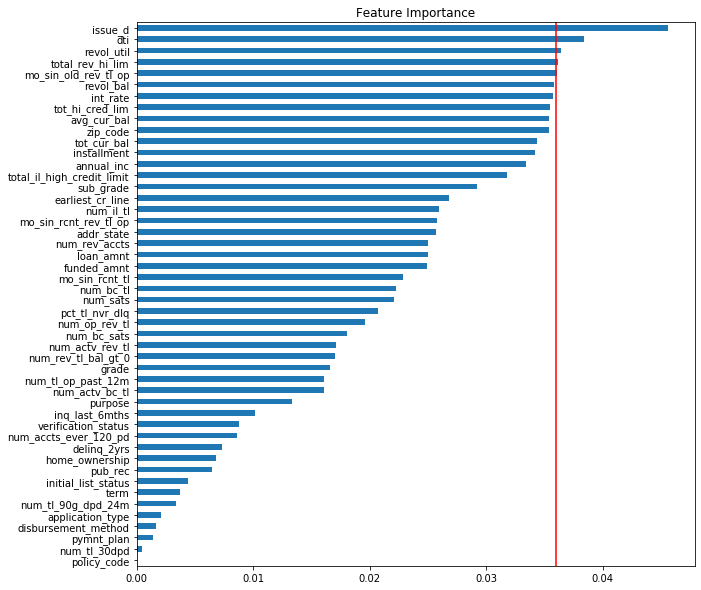

In [34]:
# Plot the name and gini importance of each feature
plt.rcParams["figure.figsize"] = (10, 10)
imp_features=pd.Series(rf_pipeline.named_steps['classifier'].feature_importances_, index=X.columns)
imp_features.sort_values().plot(title='Feature Importance', kind='barh')

# draw red verticle line at threshold
plt.axvline(x=0.036, c='r')

In [35]:
#show important features
important_features = list(imp_features[imp_features > 0.036].keys())
X[important_features].head()

,issue_d,dti,revol_util,total_rev_hi_lim,mo_sin_old_rev_tl_op
0,2018,18.24,10.3,42000,212
1,2018,26.52,24.2,50800,378
2,2018,10.51,19.1,24100,92
3,2018,16.74,78.1,7000,154
4,2018,26.35,3.6,23100,216


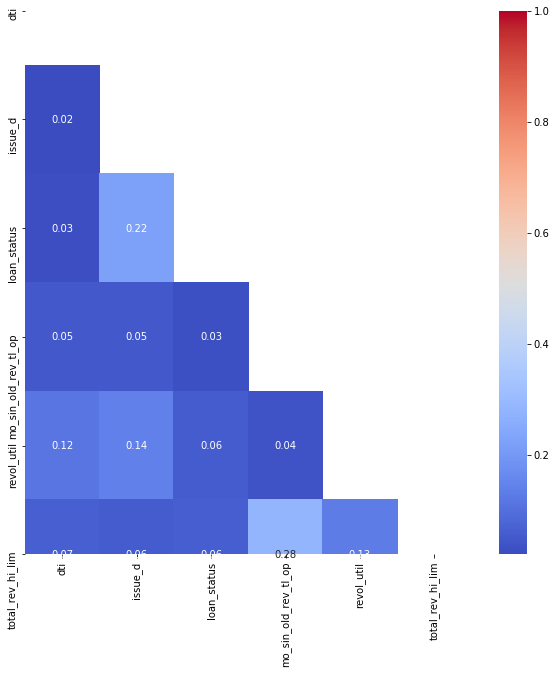

In [36]:
import seaborn as sns
plt.rcParams["figure.figsize"] = (10, 10)

corr = data[np.union1d(important_features, target)].corr().abs()

# Generate a mask to ignore upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot heatmap
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, mask=mask, cmap='coolwarm', fmt='.2f')

In [37]:
from sklearn.feature_selection import SelectFromModel
select_important_features = SelectFromModel(rf_pipeline.named_steps['classifier'], threshold=0.036)

### Gradient Boosting Classifier

In [39]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

param_grid = {
    'n_estimators': [10, 100],
    'max_features': [None, 'sqrt'],
    'learning_rate': [0.1, 0.5],
    #'max_leaf_nodes': [2, 8],
    #'min_samples_split': [0.1, 0.3]
}

gb_pipeline = Pipeline([
    ('imputer', SimpleImputer()), # fill missing values with mean of column
    ('selector', select_important_features), # select only the important features
    ('scaler', MinMaxScaler()), # scale values to range [0,1]
    ('classifier', GridSearchCV(GradientBoostingClassifier(), param_grid=param_grid, cv=3, refit=True, n_jobs=-1))
])
gb_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('imputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('selector',
                 SelectFromModel(estimator=RandomForestClassifier(bootstrap=True,
                                                                  class_weight=None,
                                                                  criterion='gini',
                                                                  max_depth=None,
                                                                  max_features='auto',
                                                                  max_leaf_nodes=None,
                                                                  min_impurity_decrease=0.0,
                                                                  min_impurity...
                                               

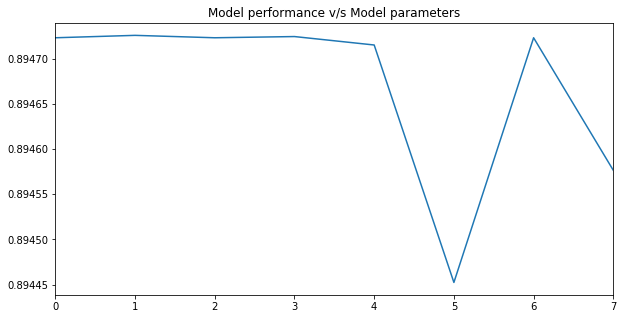

In [40]:
plt.rcParams["figure.figsize"] = (10, 5)

series=pd.Series(gb_pipeline.named_steps['classifier'].cv_results_['mean_test_score'])
series.plot(title='Model performance v/s Model parameters')

In [41]:
gb_pipeline.named_steps['classifier'].best_score_

0.8947259518730426

In [42]:
gb_pipeline.named_steps['classifier'].best_params_

{'learning_rate': 0.1, 'max_features': None, 'n_estimators': 100}

In [43]:
# Calculate area under the ROC curve score

from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, gb_pipeline.predict(X_test))

0.5000167820775738

Text(0, 0.5, 'Actual')

<Figure size 360x360 with 0 Axes>

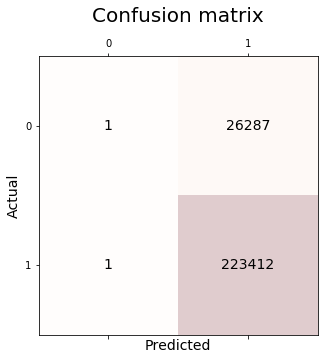

In [44]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix

predictions = gb_pipeline.predict(X_test)
conf_mat = confusion_matrix(y_test, predictions)

plt.rcParams["figure.figsize"] = (5, 5)
plt.figure(figsize=(5, 5))
plt.matshow(conf_mat, cmap=plt.cm.Reds, alpha=0.2)

for i in range(2):
    for j in range(2):
        plt.text(x=j, y=i, s=conf_mat[i, j], ha="center", va="center", fontdict={"fontsize": 14})

plt.title("Confusion matrix", y=1.1, fontdict={"fontsize": 20})
plt.xlabel("Predicted", fontdict={"fontsize": 14})
plt.ylabel("Actual", fontdict={"fontsize": 14})

### Neural Networks

In [45]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier

def build_classifier(optimizer='adam', layers=2, add_dropout_layers=False, dropout_rate=0.1):
    # first step: create a Sequential object, as a sequence of layers. B/C NN is a sequence of layers.
    classifier = Sequential()
    
    for i in range(layers):
        # add the hidden layer
        classifier.add(Dense(units=5,kernel_initializer='glorot_uniform',activation = 'relu'))
        
        # add dropout layer
        if add_dropout_layers:
            classifier.add(Dropout(rate=dropout_rate))  #often start with 0.1, not solved go up
    
    # add the output layer
    classifier.add(Dense(units=1,kernel_initializer='glorot_uniform',activation = 'sigmoid'))
    
    # compiling the NN
    classifier.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])
    return classifier


classifier = KerasClassifier(build_fn=build_classifier, batch_size=10, nb_epoch=3)

param_grid = {
    'batch_size':[10, 100], 
    'nb_epoch':[1, 10],
    #'optimizer':['adam','rmsprop'],
    'layers': [0, 1, 2],
    #'add_dropout_layers': [False, True]
}

nn_pipeline = Pipeline([
    ('imputer', SimpleImputer()),  # fill missing values with mean of column
    ('selector', select_important_features),  # select only the important features
    ('scaler', MinMaxScaler()),  # scale values to range [0,1]
    ('classifier', GridSearchCV(classifier, param_grid=param_grid, cv=3, scoring='accuracy', refit=True, n_jobs=-1))  
])
nn_pipeline.fit(X_train, y_train)

Using TensorFlow backend.


Epoch 1/1
749102/749102 [==============================] - 6s 8us/step - loss: 0.3176 - accuracy: 0.8937


Pipeline(memory=None,
         steps=[('imputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('selector',
                 SelectFromModel(estimator=RandomForestClassifier(bootstrap=True,
                                                                  class_weight=None,
                                                                  criterion='gini',
                                                                  max_depth=None,
                                                                  max_features='auto',
                                                                  max_leaf_nodes=None,
                                                                  min_impurity_decrease=0.0,
                                                                  min_impurity...
                ('scaler', MinMaxScaler(copy=Tr

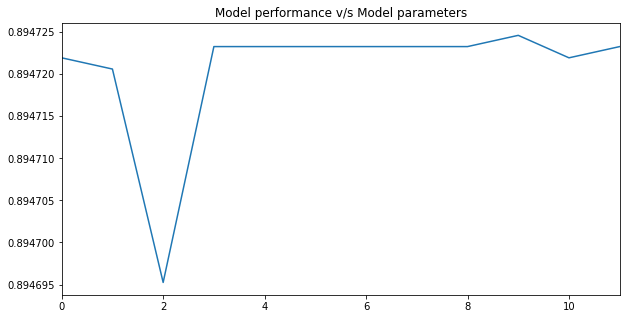

In [46]:
plt.rcParams["figure.figsize"] = (10, 5)

series=pd.Series(nn_pipeline.named_steps['classifier'].cv_results_['mean_test_score'])
series.plot(title='Model performance v/s Model parameters')

In [47]:
nn_pipeline.named_steps['classifier'].best_score_

0.8947246169413511

In [48]:
nn_pipeline.named_steps['classifier'].best_params_

{'batch_size': 100, 'layers': 1, 'nb_epoch': 10}

In [49]:
roc_auc_score(y_test, nn_pipeline.predict(X_test))

0.5

Text(0, 0.5, 'Actual')

<Figure size 360x360 with 0 Axes>

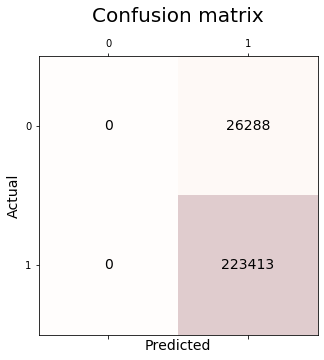

In [50]:
# Confusion Matrix
predictions = nn_pipeline.predict(X_test)
conf_mat = confusion_matrix(y_test, predictions)

plt.rcParams["figure.figsize"] = (5, 5)
plt.figure(figsize=(5, 5))
plt.matshow(conf_mat, cmap=plt.cm.Reds, alpha=0.2)

for i in range(2):
    for j in range(2):
        plt.text(x=j, y=i, s=conf_mat[i, j], ha="center", va="center", fontdict={"fontsize": 14})

plt.title("Confusion matrix", y=1.1, fontdict={"fontsize": 20})
plt.xlabel("Predicted", fontdict={"fontsize": 14})
plt.ylabel("Actual", fontdict={"fontsize": 14})